In [ ]:
# uploaded = files.upload()
# import os
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/spotify-f1cf5-firebase-adminsdk-xxrd4-763e07c601.json'
# import firebase_admin
# from firebase_admin import credentials
# from google.cloud import firestore

In [ ]:
# cred = credentials.Certificate('/content/spotify-f1cf5-firebase.json')
# firebase_admin.initialize_app(cred, {
#     'databaseURL': 'https://spotify-f1cf5.firebaseio.com'
# })

# db = firestore.Client()

# tracks_ref = db.collection(u'tracks')
# tracks = tracks_ref.stream()

# track_list = []
# for track in tracks:
#   track_list.append(track.to_dict())
# track_table = pd.DataFrame(track_list)

In [110]:
import pandas as pd
import numpy as np
from google.colab import files
uploaded = files.upload()

Saving cleaned_tracks_both.csv to cleaned_tracks_both.csv


In [111]:
track_table = pd.read_csv("cleaned_tracks_both.csv")

In [112]:
track_table.head()

,track_pop,track_name,track_id,track_year,track_spotify_genre,art_name,art_id,alb_name,alb_id,art_genre,duration_ms,time_signature,key,loudness,energy,speechiness,acousticness,mode,tempo,valence,danceability,instrumentalness,liveness,genre_words,master_popular_genre
0,50,"Turandot / Act 3: Turandot / Act 3: ""Nessun do...",1GqszY8D6qlMHY7KmA5wE8,2011,classical,Andrea Bocelli,3EA9hVIzKfFiQI0Kikz2wo,Concerto: One Night In Central Park (Remastered),7LkXjMXDhwqXl3l9zqxRRz,"['classical tenor', 'italian tenor', 'operatic...",247010,4,2,-9.841,0.41200,0.0357,0.94300,1,88.113,0.193,0.167,0.000121,0.7570,"{'classical': 1, 'tenor': 2, 'italian': 1, 'op...",pop
1,44,Bad Asteroid,5TzCDKy1ZmFZdW8100A8p9,2011,classical,The Aristocrats,1V4jsLjkic1Mxvdke86Qth,The Aristocrats,7GKzcJbW0Qernh0Xab1bIf,"['instrumental rock', 'jazz fusion', 'neo clas...",353667,4,11,-7.257,0.72700,0.0462,0.03010,0,87.349,0.391,0.485,0.758000,0.1630,"{'instrumental': 1, 'rock': 1, 'jazz': 2, 'fus...",rock
2,37,The Whispers,4VH3rKj1tmhUZtX3U43jBq,2011,classical,Harold Budd,3uOCouLFR4bVx0XeiQJSbl,In The Mist,3J8bwfrUYrzmuE0IqFLhUS,"['ambient', 'american contemporary classical',...",163000,3,9,-35.213,0.00385,0.0449,0.99500,0,141.201,0.117,0.228,0.917000,0.0858,"{'ambient': 2, 'american': 1, 'contemporary': ...",rock
3,41,"Time To Say Goodbye - Live At Central Park, Ne...",1Jw2mwSScPEROBomYw6L0g,2011,classical,Andrea Bocelli,3EA9hVIzKfFiQI0Kikz2wo,Concerto: One Night In Central Park (Remastered),7LkXjMXDhwqXl3l9zqxRRz,"['classical tenor', 'italian tenor', 'operatic...",253991,3,7,-9.827,0.30500,0.0318,0.93600,1,85.786,0.446,0.230,0.000002,0.7440,"{'classical': 1, 'tenor': 2, 'italian': 1, 'op...",pop
4,42,Anthem,0ZUPWnw89a0iLfNdcUiIm3,2011,classical,Iced Earth,3KEixcRfBS5K3E91Vn1Kdy,Dystopia,6la9AnaFIgSo4faEDcnHQx,"['hard rock', 'melodic metal', 'metal', 'neo c...",294613,4,3,-5.242,0.95400,0.0607,0.00894,0,163.995,0.287,0.454,0.000000,0.0659,"{'hard': 1, 'rock': 1, 'melodic': 1, 'metal': ...",rock


In [113]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
track_table_numerics = track_table.select_dtypes(include=[np.number])

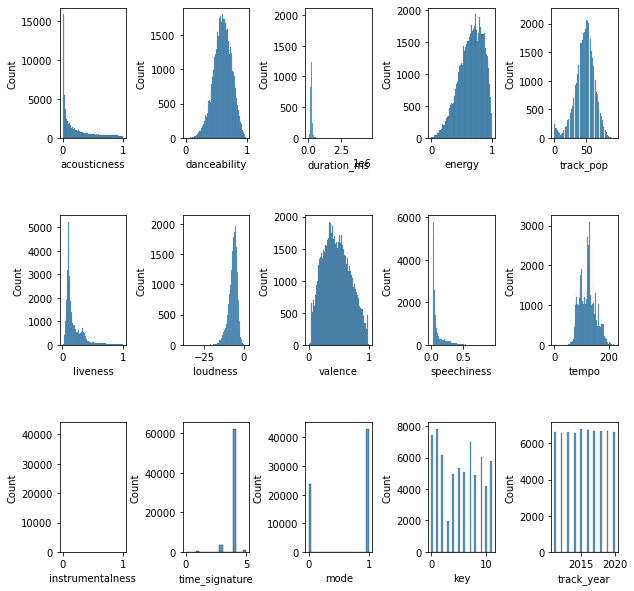

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt
 
f, axes = plt.subplots(3, 5, figsize=(10, 10))
plt.subplots_adjust(wspace=.85, hspace=.6)
sns.histplot( track_table_numerics["acousticness"] , ax=axes[0, 0])
sns.histplot( track_table_numerics["danceability"] , ax=axes[0, 1])
sns.histplot( track_table_numerics["duration_ms"] , ax=axes[0, 2])
sns.histplot( track_table_numerics["energy"] , ax=axes[0, 3])
sns.histplot( track_table_numerics["track_pop"] , ax=axes[0, 4])
sns.histplot( track_table_numerics["liveness"] , ax=axes[1, 0])
sns.histplot( track_table_numerics["loudness"] , ax=axes[1, 1])
sns.histplot( track_table_numerics["valence"] , ax=axes[1, 2])
sns.histplot( track_table_numerics["speechiness"] , ax=axes[1, 3])
sns.histplot( track_table_numerics["tempo"] , ax=axes[1, 4])
sns.histplot( track_table_numerics["instrumentalness"] , ax=axes[2, 0])
sns.histplot( track_table_numerics["time_signature"] , ax=axes[2, 1])
sns.histplot( track_table_numerics["mode"] , ax=axes[2, 2])
sns.histplot( track_table_numerics["key"] , ax=axes[2, 3])
sns.histplot( track_table_numerics["track_year"] , ax=axes[2, 4])

In [36]:
#rescaling target variable

#from sklearn.preprocessing import MinMaxScaler
#min_max_scaler = MinMaxScaler()
#track_table[["track_pop"]] = min_max_scaler.fit_transform(track_table[["track_pop"]])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


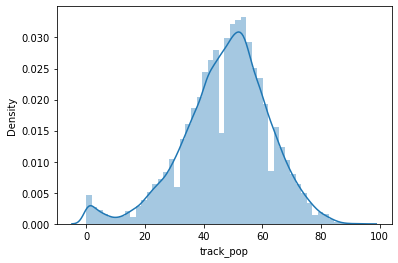

In [115]:
sns.distplot( track_table_numerics["track_pop"])

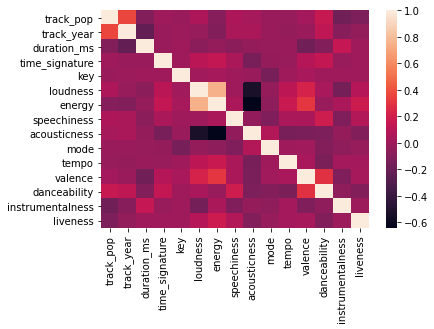

In [116]:
sns.heatmap(track_table_numerics.corr())

Might be worth dropping Instrumentalness, high p-value anyway. or Loudness?


In [93]:
track_table_dummies = pd.get_dummies(track_table,columns=['key','time_signature','track_spotify_genre'],drop_first=True)
track_table_dummies.drop(['loudness', 'master_popular_genre'], axis=1, inplace=True)
track_table_dummies = track_table_dummies.select_dtypes(include=[np.number])
track_table_dummies.dropna(inplace=True)
#track_table_dummies = pd.get_dummies(track_table_numerics,columns=['time_signature','mode'],drop_first=True)

In [94]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm

In [95]:
X = track_table_dummies.iloc[:,1:]
y = track_table_dummies.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [96]:
track_table_dummies

,track_pop,track_year,duration_ms,energy,speechiness,acousticness,mode,tempo,valence,danceability,instrumentalness,liveness,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_1,time_signature_3,time_signature_4,time_signature_5,track_spotify_genre_country,track_spotify_genre_hip-hop,track_spotify_genre_house,track_spotify_genre_indie,track_spotify_genre_pop,track_spotify_genre_r&b,track_spotify_genre_rock
0,50,2011,247010,0.41200,0.0357,0.94300,1,88.113,0.1930,0.1670,0.000121,0.7570,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,44,2011,353667,0.72700,0.0462,0.03010,0,87.349,0.3910,0.4850,0.758000,0.1630,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,39,2011,400626,0.07450,0.0361,0.93600,0,72.547,0.0322,0.0722,0.840000,0.1130,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,37,2011,163000,0.00385,0.0449,0.99500,0,141.201,0.1170,0.2280,0.917000,0.0858,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,41,2011,253991,0.30500,0.0318,0.93600,1,85.786,0.4460,0.2300,0.000002,0.7440,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66766,52,2020,270476,0.90800,0.0415,0.00001,0,110.936,0.2700,0.2970,0.848000,0.1400,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
66767,49,2020,194989,0.33100,0.0323,0.82500,1,99.093,0.5600,0.7700,0.019500,0.1580,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
66768,50,2020,192066,0.83700,0.0520,0.00324,1,121.901,0.2300,0.4760,0.000000,0.1050,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
66769,57,2020,261880,0.37100,0.0272,0.54700,1,66.853,0.1960,0.4310,0.015400,0.0921,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


## Linear Regression

In [117]:
model = sm.OLS(y_train,X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              track_pop   R-squared (uncentered):                   0.927
Model:                            OLS   Adj. R-squared (uncentered):              0.927
Method:                 Least Squares   F-statistic:                          1.713e+04
Date:                Sat, 12 Jun 2021   Prob (F-statistic):                        0.00
Time:                        01:27:55   Log-Likelihood:                     -1.7989e+05
No. Observations:               44736   AIC:                                  3.599e+05
Df Residuals:                   44703   BIC:                                  3.601e+05
Df Model:                          33                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
track_year                      0.0467      0.003     14.054      0.000       0.040       0.053
duration_ms                  -1.06e-05   9.64e-07    -11.000      0.000   -1.25e-05   -8.72e-06
energy                         -5.4438      0.482    -11.300      0.000      -6.388      -4.500
speechiness                     3.2250      0.737      4.374      0.000       1.780       4.670
acousticness                    0.4705      0.333      1.415      0.157      -0.181       1.122
mode                           -0.5027      0.143     -3.525      0.000      -0.782      -0.223
tempo                           0.0039      0.002      1.664      0.096      -0.001       0.008
valence                        -1.5247      0.338     -4.507      0.000      -2.188      -0.862
danceability                   14.9511      0.545     27.448      0.000      13.883      16.019
instrumentalness              -11.1429      0.335    -33.256      0.000     -11.800     -10.486
liveness                       -9.4745      0.417    -22.741      0.000     -10.291      -8.658
key_1                           0.1715      0.269      0.637      0.524      -0.357       0.700
key_2                          -0.5530      0.285     -1.942      0.052      -1.111       0.005
key_3                           0.5323      0.414      1.285      0.199      -0.280       1.345
key_4                          -0.4761      0.307     -1.552      0.121      -1.077       0.125
key_5                           0.4666      0.298      1.564      0.118      -0.118       1.051
key_6                          -0.0435      0.302     -0.144      0.886      -0.636       0.549
key_7                          -0.4246      0.275     -1.546      0.122      -0.963       0.114
key_8                           0.8210      0.304      2.705      0.007       0.226       1.416
key_9                          -0.9772      0.286     -3.415      0.001      -1.538      -0.416
key_10                          0.3668      0.321      1.142      0.254      -0.263       0.996
key_11                         -0.0979      0.292     -0.335      0.738      -0.671       0.475
time_signature_1              -56.0646      6.778     -8.272      0.000     -69.349     -42.781
time_signature_3              -57.4242      6.708     -8.561      0.000     -70.571     -44.277
time_signature_4              -57.3409      6.704     -8.553      0.000     -70.481     -44.201
time_signature_5              -57.5226      6.726     -8.552      0.000     -70.706     -44.339
track_spotify_genre_country     4.6970      0.662      7.100      0.000       3.400       5.994
track_spotify_genre_hip-hop    12.5855      0.677     18.587      0.000      11.258      13.913
track_sp

In [99]:
print("Linear Regression:")
print("Test mean absolute error:", mean_absolute_error(y_test, results.predict(X_test)))
lr_mse = mean_squared_error(y_test,results.predict(X_test))
print("Test mean-squared error:", lr_mse)
print("Test root mean squared error:", np.sqrt(lr_mse))


Linear Regression:
Test mean absolute error: 9.958025075640368
Test mean-squared error: 177.63600840222045
Test root mean squared error: 13.328015921442338


## Random Forest

In [11]:
rf_param_grid = {
              'n_estimators':range(50,140, 20),
              'max_depth':range(3,10, 2),
              'min_samples_split': [0.05, 0.1]
}
rf_grid = GridSearchCV(RandomForestRegressor(), rf_param_grid, cv=3, verbose=2).fit(X_train, y_train)
# summarize the results of the grid search

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] max_depth=3, min_samples_split=0.05, n_estimators=50 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=3, min_samples_split=0.05, n_estimators=50, total=   4.3s
[CV] max_depth=3, min_samples_split=0.05, n_estimators=50 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV]  max_depth=3, min_samples_split=0.05, n_estimators=50, total=   4.2s
[CV] max_depth=3, min_samples_split=0.05, n_estimators=50 ............
[CV]  max_depth=3, min_samples_split=0.05, n_estimators=50, total=   4.2s
[CV] max_depth=3, min_samples_split=0.05, n_estimators=70 ............
[CV]  max_depth=3, min_samples_split=0.05, n_estimators=70, total=   5.9s
[CV] max_depth=3, min_samples_split=0.05, n_estimators=70 ............
[CV]  max_depth=3, min_samples_split=0.05, n_estimators=70, total=   5.9s
[CV] max_depth=3, min_samples_split=0.05, n_estimators=70 ............
[CV]  max_depth=3, min_samples_split=0.05, n_estimators=70, total=   5.9s
[CV] max_depth=3, min_samples_split=0.05, n_estimators=90 ............
[CV]  max_depth=3, min_samples_split=0.05, n_estimators=90, total=   7.5s
[CV] max_depth=3, min_samples_split=0.05, n_estimators=90 ............
[CV]  max_depth=3, min_samples_split=0.05, n_estimators=90, total=   7.1s
[CV] max_depth=3, min_samples_split=0.05, n_estimators=9

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 24.2min finished


In [12]:
print("The best score is {}".format(rf_grid.best_score_))
print("The best hyper parameter setting is {}".format(rf_grid.best_params_))

The best score is 0.31544239998897977
The best hyper parameter setting is {'max_depth': 9, 'min_samples_split': 0.05, 'n_estimators': 90}


In [13]:
print("Random Forest:")
print("Test mean absolute error:", mean_absolute_error(y_test, rf_grid.predict(X_test)))
rf_mse = mean_squared_error(y_test,rf_grid.predict(X_test))
print("Test mean-squared error:", rf_mse)
print("Test root mean squared error:", np.sqrt(rf_mse))

Random Forest:
Test mean absolute error: 9.994666435671931
Test mean-squared error: 184.8183583245701
Test root mean squared error: 13.594791588125583


## Gradient Boost

In [100]:
gb_param_grid = {
     #'learning_rate': [.01,.1,1],
     'learning_rate':[.1],
     #'max_depth': [4,5,6,7],
     'max_depth':[7],
     #'n_estimators': range(50,150,20),
     'n_estimators':[130],
     #'min_samples_split': [0.01, 0.05, 0.1]
     'min_samples_split':[.01] 
}

gb_grid = GridSearchCV(GradientBoostingRegressor(), gb_param_grid, cv=3, verbose=2).fit(X_train, y_train)

# summarize the results of the grid search
print("The best score is {}".format(gb_grid.best_score_))
print("The best hyper parameter setting is {}".format(gb_grid.best_params_))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=7, min_samples_split=0.01, n_estimators=130 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=7, min_samples_split=0.01, n_estimators=130, total=  24.7s
[CV] learning_rate=0.1, max_depth=7, min_samples_split=0.01, n_estimators=130 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=7, min_samples_split=0.01, n_estimators=130, total=  24.8s
[CV] learning_rate=0.1, max_depth=7, min_samples_split=0.01, n_estimators=130 
[CV]  learning_rate=0.1, max_depth=7, min_samples_split=0.01, n_estimators=130, total=  24.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min finished


The best score is 0.4963690809306304
The best hyper parameter setting is {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_split': 0.01, 'n_estimators': 130}


In [103]:
print("Gradient Boost:")
print("Test mean absolute error:", mean_absolute_error(y_test, gb_grid.predict(X_test)))
gb_mse = mean_squared_error(y_test,gb_grid.predict(X_test))
print("Test mean-squared error:", gb_mse)
print("Test root mean squared error:", np.sqrt(gb_mse))

Gradient Boost:
Test mean absolute error: 7.640747876010466
Test mean-squared error: 107.3892953807622
Test root mean squared error: 10.362880650705295


In [104]:
print(max(gb_grid.predict(X_test)))
print(max(y_test))

75.35197011107665
94


## Neural Network

In [ ]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
nn_param_grid = {
     'activation': ['logistic', 'relu'],
     'learning_rate': ['constant','adaptive'],
     'learning_rate_init': [.001,.01],
     'hidden_layer_sizes': [3,5,10,50,100],
     'max_iter': [400]

}

nn_grid = GridSearchCV(MLPRegressor(), nn_param_grid, cv=3).fit(X_train, y_train)

# summarize the results of the grid search
print("The best score is {}".format(nn_grid.best_score_))
print("The best hyper parameter setting is {}".format(nn_grid.best_params_))

The best score is -8.038546307857312e-07
The best hyper parameter setting is {'activation': 'logistic', 'hidden_layer_sizes': 10, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 400}


In [ ]:
print("Neural Network:")
print("Test mean absolute error:", mean_absolute_error(y_test, nn_grid.predict(X_test)))
nn_mse = mean_squared_error(y_test,nn_grid.predict(X_test))
print("Test mean-squared error:", mse)
print("Test root mean squared error:", np.sqrt(mse))

Neural Network:
Test mean absolute error: 13.12576867922241
Test mean-squared error: 271.698105917296
Test root mean squared error: 16.483267452701725


## SVM

In [ ]:
from sklearn.svm import SVR

In [ ]:
svm_param_grid = {
    #'degree': [1],
    #'degree': [1,2,3,4],
    'kernel': ['linear']
}

svm_grid = GridSearchCV( SVR(), svm_param_grid, cv= 3, verbose=2).fit(X_train, y_train)

# summarize the results of the grid search
print("The best score is {}".format(svm_grid.best_score_))
print("The best hyper parameter setting is {}".format(svm_grid.best_params_))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] kernel=linear ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
print("SVM:")
print("Test mean absolute error:", mean_absolute_error(y_test, svm_grid.predict(X_test)))
mse = mean_squared_error(y_test,svm_grid.predict(X_test))
print("Test mean-squared error:", mse)
print("Test root mean squared error:", np.sqrt(mse))

In [ ]:
gb_pred = svm_grid.predict(X_test)
plt.scatter(x=gb_pred, y=y_test, alpha=.5, color = 'b', label = "Gradient Boost")
#plt.scatter(x=ada_pred, y=test_y, alpha=.5, color = 'r', label = "Ada Boost")
plt.plot(y_test, y_test, color = 'g', label = 'Perfect Fit')
plt.xlabel('Predicted Popularity')
plt.ylabel('Actual Popularity')
plt.legend(loc='upper left')
plt.title("Predicted Popularity vs. Actual Popularity")
plt.figure(figsize=(12,8))

## Visualizing Error

<Figure size 864x576 with 0 Axes>

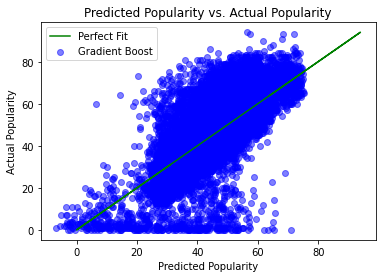

<Figure size 864x576 with 0 Axes>

In [105]:
gb_pred = gb_grid.predict(X_test)
plt.scatter(x=gb_pred, y=y_test, alpha=.5, color = 'b', label = "Gradient Boost")
#plt.scatter(x=ada_pred, y=test_y, alpha=.5, color = 'r', label = "Ada Boost")
plt.plot(y_test, y_test, color = 'g', label = 'Perfect Fit')
plt.xlabel('Predicted Popularity')
plt.ylabel('Actual Popularity')
plt.legend(loc='upper left')
plt.title("Predicted Popularity vs. Actual Popularity")
plt.figure(figsize=(12,8))

<Figure size 864x576 with 0 Axes>

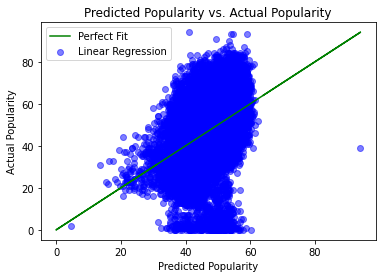

<Figure size 864x576 with 0 Axes>

In [106]:
reg_pred = results.predict(X_test)
plt.scatter(x=reg_pred, y=y_test, alpha=.5, color = 'b', label = "Linear Regression")
#plt.scatter(x=ada_pred, y=test_y, alpha=.5, color = 'r', label = "Ada Boost")
plt.plot(y_test, y_test, color = 'g', label = 'Perfect Fit')
plt.xlabel('Predicted Popularity')
plt.ylabel('Actual Popularity')
plt.legend(loc='upper left')
plt.title("Predicted Popularity vs. Actual Popularity")
plt.figure(figsize=(12,8))

Add error analysis per genre (violin)

histogram of error